<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This tutorial is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>, except for figures of external sources as indicated. It is partly based on the tutorial prepared by Marcus Voss and Nikola Milojevic-Dupont for participants of the WiDS Datathon 2022 and the Climate Change AI Summer School 2022 as available [here](https://colab.research.google.com/drive/1uqh5ruT0cYjfinWH3LKyp0Mo2ud3EJwz).

Example Code Walkthrough: Low Voltage Load Forecasting
==============

Author: [Marcus Voss](mailto:voss.marcus@gmail.com) – *Birds on Mars, TU Berlin, Climate Change AI*

Author: [Stephen Haben](mailto:stephen.haben@maths.ox.ac.uk) - *Mathematical Institute, University of Oxford*


# Summary

In this walkthrough, we demonstrate some of the techniques and methods for low voltage load forecasting as described in the Open Access book <a rel="license" href="https://link.springer.com/book/10.1007/978-3-031-27852-5"> "Core Methods and Concepts in Load Forecasting" </a>. 

Topics covered will include:

- **Exploratory data analysis** using common Python plotting libraries <a rel="license" href="https://matplotlib.org/stable/index.html">matplotlib</a> and <a rel="license" href="https://seaborn.pydata.org/index.html">Seaborn</a>. What are some of the features and patterns in the data and how can we identify them?
- **Feature modelling** using common Python data library <a rel="license" href="https://pandas.pydata.org/">Pandas</a>. It shows how to derive features from EDA and domain knowlege and calculating them manually. Note, that one can also use libraries like [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html) to support in generating more general time series features. 
- **Cross-validation** using machine learning library <a rel="license" href="https://scikit-learn.org/stable/">Scikit-learn</a>. How do we choose the model hyperparameters and check which models may generalise the best?
- **Model fitting and selection** (including simple benchmarks) in Python. It also shows how to manually use sklearn to apply machine learning to the time series forecasting problem. Libraries like [sktime](https://www.sktime.org/en/stable/), [tslearn](https://github.com/tslearn-team/tslearn/tree/main/tslearn), and [darts](https://unit8co.github.io/darts/#forecasting-models) can make this a bit easier with fewer lines of code.  
- Model evaluation and diagnosis.** How do we compute the errors and identify areas for improvement? We will discuss some time series specific model diagnostics. 

Some of the concepts demonstrated in this tutorial may be useful for other time series tasks beyond load forecasting.

If you have problems running this notebook, see [the description](https://github.com/low-voltage-loadforecasting/book-case-study) in the repository that hosts this notebook.

# Outline

1. [Time Series Forecasting](#tsforecasting)
1. [Time Series Data in Pandas](#pandas)
1. [Exploratory Data Analysis](#eda)
1. [Load Forecasting Features](#features)
1. [Preparing the Data for Training and Testing](#inputoutput)
1. [Model Fitting](#modelfit)
1. [Model diagnostics](#diagnostics)
1. [Cross-validation for time series](#crossvalidation)
1. [Where to go from here?](#sota)
1. [References](#references)
1. [Selected Ressources on Time Series](#ressources)

# Time Series Forecasting <a name="tsforecasting"></a>

As described in <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_4">Chapter 4</a>, supervised machine learning algorithms aim to learn the relationship (a function **f**) between a set of input variables referred to as features (or independent variables) that are typically measured or preset and have some influence on one or several output variables. These features are often denoted as a matrix $\mathbf{X}$. When the task is to predict a numeric variable, i.e., for regression problems, the output is referred to as target (or dependent variable) and often denoted as a vector $\mathbf{y}$. The relationship between the inputs and outputs are related via the following relationships including some error $\epsilon$

$$\mathbf{y} = f(\mathbf{X})+ \epsilon$$

Time series forecasting problems can be formulated as supervised learning problem (<a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_5">Chapter 5</a>) which makes them ammenable to a wealth of machine learning (<a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_10">Chapter 10</a>) and statistical (<a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_9">Chapter 9</a>) methods, some of which will be demonstrated in this tutorial. For load forecasting the output vector is the next few time steps in the forecast horizon, and the inputs can also include lagged values of the load. 


| 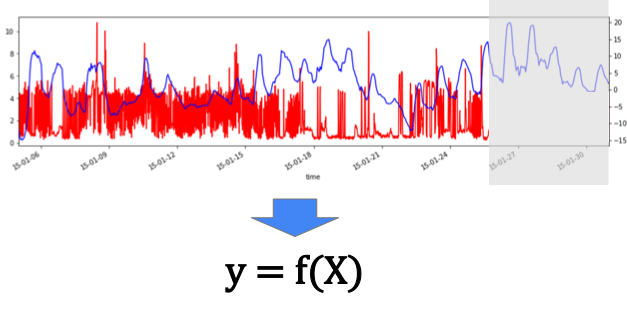 | 
|:--:| 
| *Source: Own figure* |

The next section loads some example load time series and this will be analysed to help identify useful features to include in the forecast models. 

# Loading and Processing Time Series Data into Pandas  <a name="pandas"></a>

We start by loading all the necessary packages which will be used for this task.

In [2]:
# Library for data manipulation and analysis that can handle structured data of different data types and time series.
import pandas as pd  

# Library for numerical computing and fast matrix manipulation in Python.
import numpy as np  

# Library for creating static and interactive visualizations in Python.
import matplotlib.pyplot as plt  

# Library based on matplotlib that provides additional features for creating visualizations.
import seaborn as sns  

# Library for statistical analysis and time series analysis and modeling.
from statsmodels.graphics.tsaplots import plot_acf  

# Library for fitting and evaluating different classic machine learning models and data preprocessing.
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, TimeSeriesSplit  
from sklearn.linear_model import Ridge  
from sklearn.neighbors import KNeighborsRegressor  
from sklearn.multioutput import MultiOutputRegressor  
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error  

# Library for deep learning modeling and neural networks.
from tensorflow.keras import Sequential, Input  
from tensorflow.keras.layers import Dense  

2023-05-01 20:08:18.074065: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


For this tutorial, we use distribution network data from the [Hierarchical Demand Forecasting Benchmark for the Distribution Grid](https://zenodo.org/record/4549296#.ZE98HOxBya0), which is available under [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0/legalcode).

We use the reduced dataset which is provided as a __pickle file__. A Python pickle file is a serialised binary file that can store and retrieve Python objects, allowing easy data transfer and persistence across different systems or applications. The provided pickle file is already a serialised __Pandas DataFrame__. A Pandas DataFrame is a two-dimensional table-like data structure that stores data in rows and columns, similar to a spreadsheet, and provides a powerful and flexible tool for data manipulation and analysis in Python. With pandas, we can read the DataFrame directly from a URL. 

The `head()` function shows us the top 5 rows of the DataFrame.


In [3]:
LV_PICKLE = "https://zenodo.org/record/4549296/files/reduced_dataset.pk?download=1"
reduced_data = pd.read_pickle(LV_PICKLE)
reduced_data.head()

,0307a3cec15787560b7d0ba094f74d1decb2fa72,0f415416ff153479d65f54df3fa9974af46e3a89,1caab5f0e80231e1c6fdefc00edec4fdb6a02c5f,27fbb11689277a30f5db9c71b42e1d3826bd34ff,2ce3e7e1a5365dc54c7f4fc6284f0052397702b9,2d837275047e5fdce39fda42b541dbf6c858a4d1,350c6b9720ebb1e1a04e8f88ad0fa114c2af77b3,39f06481738604cb5916dce15639e380514b99ca,432650b919537d23cb4054fdb85a07eecaa4524c,49228b90116c6075fabcd8a1cf0e48e016373614,...,fe2245a4afe0afc24d215dd4abd2ffb34610dd27,all,S1,S2,S11,S12,S21,S22,ghi_backwards,temperature
2018-01-13 00:10:00+00:00,9.786000,20.518000,10.653333,19.190333,23.088333,41.712000,24.278000,12.349333,28.300333,11.307000,...,17.921333,581.757667,246.314000,335.443667,124.948000,121.366000,167.890667,167.553000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0361272897446...","[3.6288461538461543, 3.589157030333501, 3.4878..."
2018-01-13 00:20:00+00:00,11.190000,20.086333,9.367333,19.794000,22.374667,43.572667,23.853333,10.230667,30.275333,13.225333,...,16.359333,580.896333,250.185333,330.711000,126.385000,123.800333,165.354333,165.356667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.9360517716272...","[3.6256410256410265, 3.5733366851013924, 3.477..."
2018-01-13 00:30:00+00:00,10.712333,19.977333,12.999333,19.607000,22.249000,39.306333,23.938667,10.445000,31.299667,11.968000,...,16.344667,579.949667,250.906000,329.043667,124.851333,126.054667,163.161000,165.882667,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.3870873646209...","[3.620769230769231, 3.554524886877828, 3.46849..."
2018-01-13 00:40:00+00:00,12.445000,20.049667,11.751333,19.233333,22.755333,35.916333,24.074000,9.907000,29.984000,12.003667,...,24.532000,569.836667,247.367333,322.469333,122.151000,125.216333,167.244000,155.225333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 14.076547987698...","[3.6146153846153846, 3.53470755823697, 3.45838..."
2018-01-13 00:50:00+00:00,10.487000,19.225333,10.183667,20.226667,22.375333,36.360000,25.039667,10.479667,32.333000,11.688000,...,19.819333,552.787667,246.735000,306.052667,118.858000,127.877000,169.919333,136.133333,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 20.691747559834...","[3.6075641025641025, 3.515870621752975, 3.4460..."


With the `dtypes` property we can display the datatypes of the DataFrame and see that most of the columns are so-called float values (numeric data) and the weather data is provided as an array for 24h ahead.

In [4]:
reduced_data.dtypes

0307a3cec15787560b7d0ba094f74d1decb2fa72    float64
0f415416ff153479d65f54df3fa9974af46e3a89    float64
1caab5f0e80231e1c6fdefc00edec4fdb6a02c5f    float64
27fbb11689277a30f5db9c71b42e1d3826bd34ff    float64
2ce3e7e1a5365dc54c7f4fc6284f0052397702b9    float64
2d837275047e5fdce39fda42b541dbf6c858a4d1    float64
350c6b9720ebb1e1a04e8f88ad0fa114c2af77b3    float64
39f06481738604cb5916dce15639e380514b99ca    float64
432650b919537d23cb4054fdb85a07eecaa4524c    float64
49228b90116c6075fabcd8a1cf0e48e016373614    float64
4db83178615678a918dfa6a38ae6e23de7a2d39a    float64
5e9c55269b890ad82c8ebbd146ea2a563fe768ce    float64
75d0930659fc8dcdaffed6c60d5871a969a76a87    float64
7bf877fd51c1c6db07c1fb0255eac4540030f28f    float64
7ebc4dd008e424c2510c6581a195524563b00ee9    float64
89819f031b89125c8c4b364317478f078925fe38    float64
a0ab25616dde3d31062ade71f866faa3b1e8e18f    float64
a4656735af4aa0ba2e4758f8d4f6e411cfc55097    float64
a52f9650e9aa3d60e43792eb2574e0e76bb00aaf    float64
b3e1bf5d8d03

Another useful function to start exploring data is the `describe()` function to see some summary statistics of the data:


In [5]:
reduced_data.describe()

,0307a3cec15787560b7d0ba094f74d1decb2fa72,0f415416ff153479d65f54df3fa9974af46e3a89,1caab5f0e80231e1c6fdefc00edec4fdb6a02c5f,27fbb11689277a30f5db9c71b42e1d3826bd34ff,2ce3e7e1a5365dc54c7f4fc6284f0052397702b9,2d837275047e5fdce39fda42b541dbf6c858a4d1,350c6b9720ebb1e1a04e8f88ad0fa114c2af77b3,39f06481738604cb5916dce15639e380514b99ca,432650b919537d23cb4054fdb85a07eecaa4524c,49228b90116c6075fabcd8a1cf0e48e016373614,...,c55a669913fe883d9ec913821688656ea8e4c884,da3ac5e45e56e0e2263f39f38c033366f5d1e0c4,fe2245a4afe0afc24d215dd4abd2ffb34610dd27,all,S1,S2,S11,S12,S21,S22
count,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,...,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000,53567.000000
mean,13.240284,22.995156,9.776394,23.409058,42.297274,42.363555,43.061240,15.992425,23.213292,22.036557,...,9.500622,16.908564,17.898915,654.890104,316.909475,337.980629,154.081720,162.827755,203.625334,134.355294
std,3.613890,9.283810,4.321372,10.983450,15.457465,9.450393,22.673602,4.955729,10.423126,7.713438,...,3.097071,5.711766,5.125619,140.720468,77.457621,72.814489,36.695086,43.436695,43.601004,33.381937
min,2.569000,5.537333,-2.524667,4.218333,15.521667,19.019000,12.510667,6.547667,0.899667,5.951333,...,0.394667,5.026333,0.000000,282.575000,143.915333,138.659667,75.820000,68.095333,85.056333,43.890000
25%,10.508333,16.032333,6.351000,14.176333,29.564333,34.611333,24.798000,12.239833,14.003833,16.296167,...,7.274000,12.531000,14.356000,543.044833,251.416333,286.825000,121.093167,127.693833,170.937667,110.125167
50%,12.560000,21.045667,9.552333,22.129333,40.218000,41.124000,31.520667,15.926333,22.098000,20.555667,...,9.145000,16.247000,17.379667,657.211333,307.865667,333.046000,152.192667,157.856667,202.199333,131.389000
75%,15.476667,28.664167,12.760500,30.224333,52.982167,49.340667,61.612333,19.082333,31.093000,26.595833,...,11.377500,20.765667,20.851833,748.181667,377.447167,387.094000,184.287500,194.403667,232.382833,157.775667
max,28.987667,62.989667,26.642333,71.555333,101.684667,76.961667,114.058667,40.236333,61.332000,70.762000,...,25.785667,41.284667,42.803000,1134.282000,541.160333,605.899000,269.400000,303.424667,369.139667,248.714000


The DataFrame already has a DateTime index, which allows us to use the powerful [timeseries manipulation methods](https://pandas.pydata.org/docs/user_guide/timeseries.html) from Pandas.

In [6]:
reduced_data.index

DatetimeIndex(['2018-01-13 00:10:00+00:00', '2018-01-13 00:20:00+00:00',
               '2018-01-13 00:30:00+00:00', '2018-01-13 00:40:00+00:00',
               '2018-01-13 00:50:00+00:00', '2018-01-13 01:00:00+00:00',
               '2018-01-13 01:10:00+00:00', '2018-01-13 01:20:00+00:00',
               '2018-01-13 01:30:00+00:00', '2018-01-13 01:40:00+00:00',
               ...
               '2019-01-19 22:20:00+00:00', '2019-01-19 22:30:00+00:00',
               '2019-01-19 22:40:00+00:00', '2019-01-19 22:50:00+00:00',
               '2019-01-19 23:00:00+00:00', '2019-01-19 23:10:00+00:00',
               '2019-01-19 23:20:00+00:00', '2019-01-19 23:30:00+00:00',
               '2019-01-19 23:40:00+00:00', '2019-01-19 23:50:00+00:00'],
              dtype='datetime64[ns, UTC]', length=53567, freq=None)

For the rest of the tutorial we will only use the load data from the _aggregation S12_ and the _temperature_ data. We can use the `resample()` function to change the resolution of the provided data from 10 minute resolution to hourly resolution. For the average load we use the `mean()` function to aggregate. For temperature we use the `first()` function to keep the first forecast of the hour.

In [7]:
load = reduced_data["S12"].to_frame().resample("1H").mean()
nwp = reduced_data.temperature.resample("1H").first().apply(pd.Series)
nwp.columns = [f"temp_{c}" for c in nwp.columns]

For the purposes of this tutorial, the dataset provided has already been cleaned. As you can read in [Chapter 6.1 Preparation and pre-processing](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_6#Sec2), in reality there are many different problems with real world data. Pandas can help you to clean up the data, and the plotting libraries such as [Matplotlib](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.plot.html) or [Seaborn](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot) or the interactive [Plotly](https://plotly.com/python/time-series/) can help you in the process.

# Exploratory Data Analysis for Feature Engineering <a name="eda"></a>

As discussed in [6.2 Feature Selection and Engineering](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_6#Sec7), there are several approaches to identifying possible features. Exploratory data analysis is the process of creating summary statistics and visualisations of your data. Again, Pandas and the aforementioned plotting libraries can help. 

 We can use Pandas' built-in plotting functions in combination with matplotlib to plot both load and temperature in one plot. For temperature, we use the first value of each forecast to show how the load compares to the corresponding forecast of the time step. Using `twinx()` we can use a second axis with a different scale as follows:

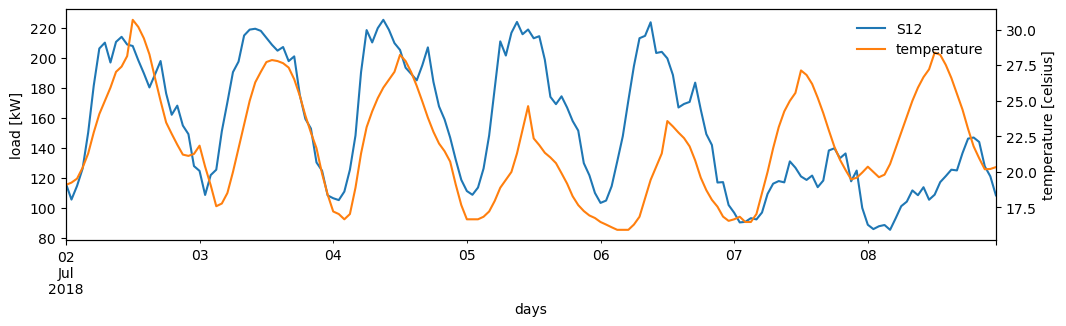

In [8]:
# create the figure with two axes
fig, ax = plt.subplots()
ax2 = ax.twinx()

# plot the data
ax = load["2018-07-02":"2018-07-08"].plot(ax=ax, figsize=(12,3),label='load', legend=False)
nwp["2018-07-02":"2018-07-08"].iloc[:,0].plot(ax=ax2, color="C1",label='temperature', legend=False)

# create legend and axes labels
handles, labels = ax.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(handles=handles+handles2, labels=labels+labels2, loc='upper right', frameon=False)
ax2.set_ylabel('temperature [celsius]')
ax.set_ylabel('load [kW]')
ax.set_xlabel('days');

We can see some correlation between the two series, but the regular pattern may also indicate autocorrelation (for more on autocorrelation see <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_3#Sec5">section 3.5</a> and <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_6#Sec7">section 6.2</a>). Let's explore these relationships further:

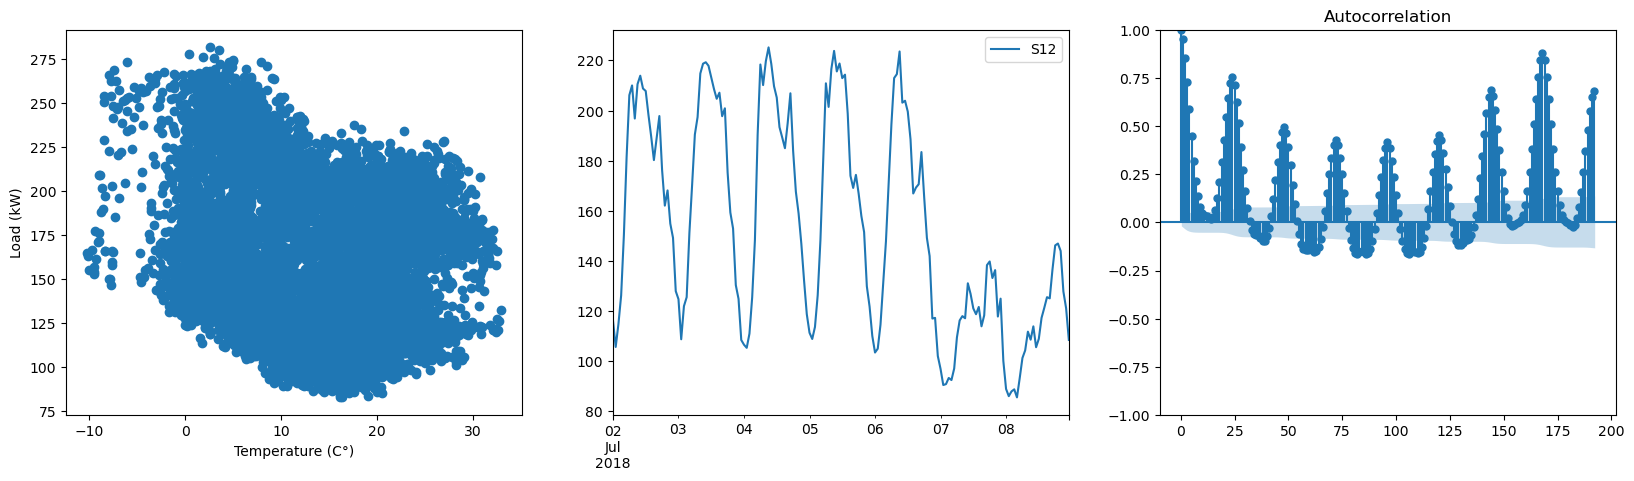

In [9]:
# create 3 subplots next to each other
fig, ax = plt.subplots(1,3, figsize=(20,5));

# create scatter plot for the first figure
ax[0].scatter(nwp.iloc[:,0], load)
ax[0].set_xlabel("Temperature (C°)")
ax[0].set_ylabel("Load (kW)")

# create a weekly plot for the second figure
load["2018-07-02":"2018-07-08"].plot(ax=ax[1])

# create a autocorrelation plot for the third figure
acf_fig = plot_acf(load, ax=ax[2], lags=8*24)

This basic EDA for load data shows that there is
- a correlation with weather information which can be exploited (but which could be related by the confounding variable of time of day! See [Chapter 13.6](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_13#Sec6) for such pitfalls),
- a seasonal component of the daily and weekly patterns that should be modelled,
- autocorrelation at multiple lags, which should be taken into account.

# Load Forecasting Features <a name="features"></a>



As discussed in (<a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_6#Sec7">Chapter 6.2</a>) there are many different things one can *generally* do. Generally in time series forecasting there are the following options:
* Add "lagged", i.e. prior, values of your target **y** (or other variables) to model autoregressive effects (use autocorrelation plots to figure out which ones are important!), 
* Add date time features features (e.g. the day of the week, month of the year, if it is a holiday yes/no, the hour of day) to model seasonal effects, 
* Moving window statistics (e.g. averages) of variables,
* Interactions of two or more variables,
* Add features of "known" external correlated time series (here: weather forecast).

While these by itself can inform machine learning models, it may be usefuly to engineer them to more elaborate features, especially for statistical models, e.g.,
* Polynomials of variables to model non-linear effects (especially for simpler models like linear regression),
* Ratios of variables,
* Utilise basis functions (<a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_6#Sec7">Chapter 6.2.5</a>)

In load forecasting the literature the most common features are (see [1] and <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_6#Sec7">Chapter 6.2.6</a>):
* weather-related variables (most importantly, temperature, humidity, solar irradiance)
* Daily, weekly and annual seasonality
* Lagged load
* Socioeconomic indicators (Number of residents, demographics, floor space, tariffs and other interventions, monthly energy consumption)

The following figure schematically shows how the feature matrix $X$ and the target vector $y$ could look for the problem of forecasting electric load:

| 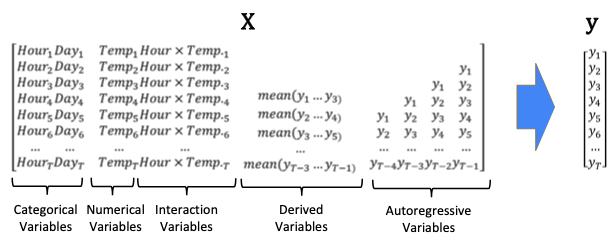 | 
|:--:| 
| *Source: Own figure.* |

(Note that creating lags leads to NaN values that need to be cut off before training models.)   

The above figure shows how one can forecast one specific point in the future (e.g., *one-step ahead* in the same resolution. Often one needs to forecast several steps ahead. This can generally be achieved using one of the following two approaches (<a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_5">Section 5.2</a>):
- a *recursive scheme*, that iteratively predicts one step at a time and uses the former iteration's forecast as input, 
- a *direct scheme*, that predicts several steps at once, either as direct output of one model or the output of several models.

The former has the advantage that it can model the dependencies between the steps in the forecast horizon. An disadvantage is that forecast errors can accumluate over the prediction horizon.


| 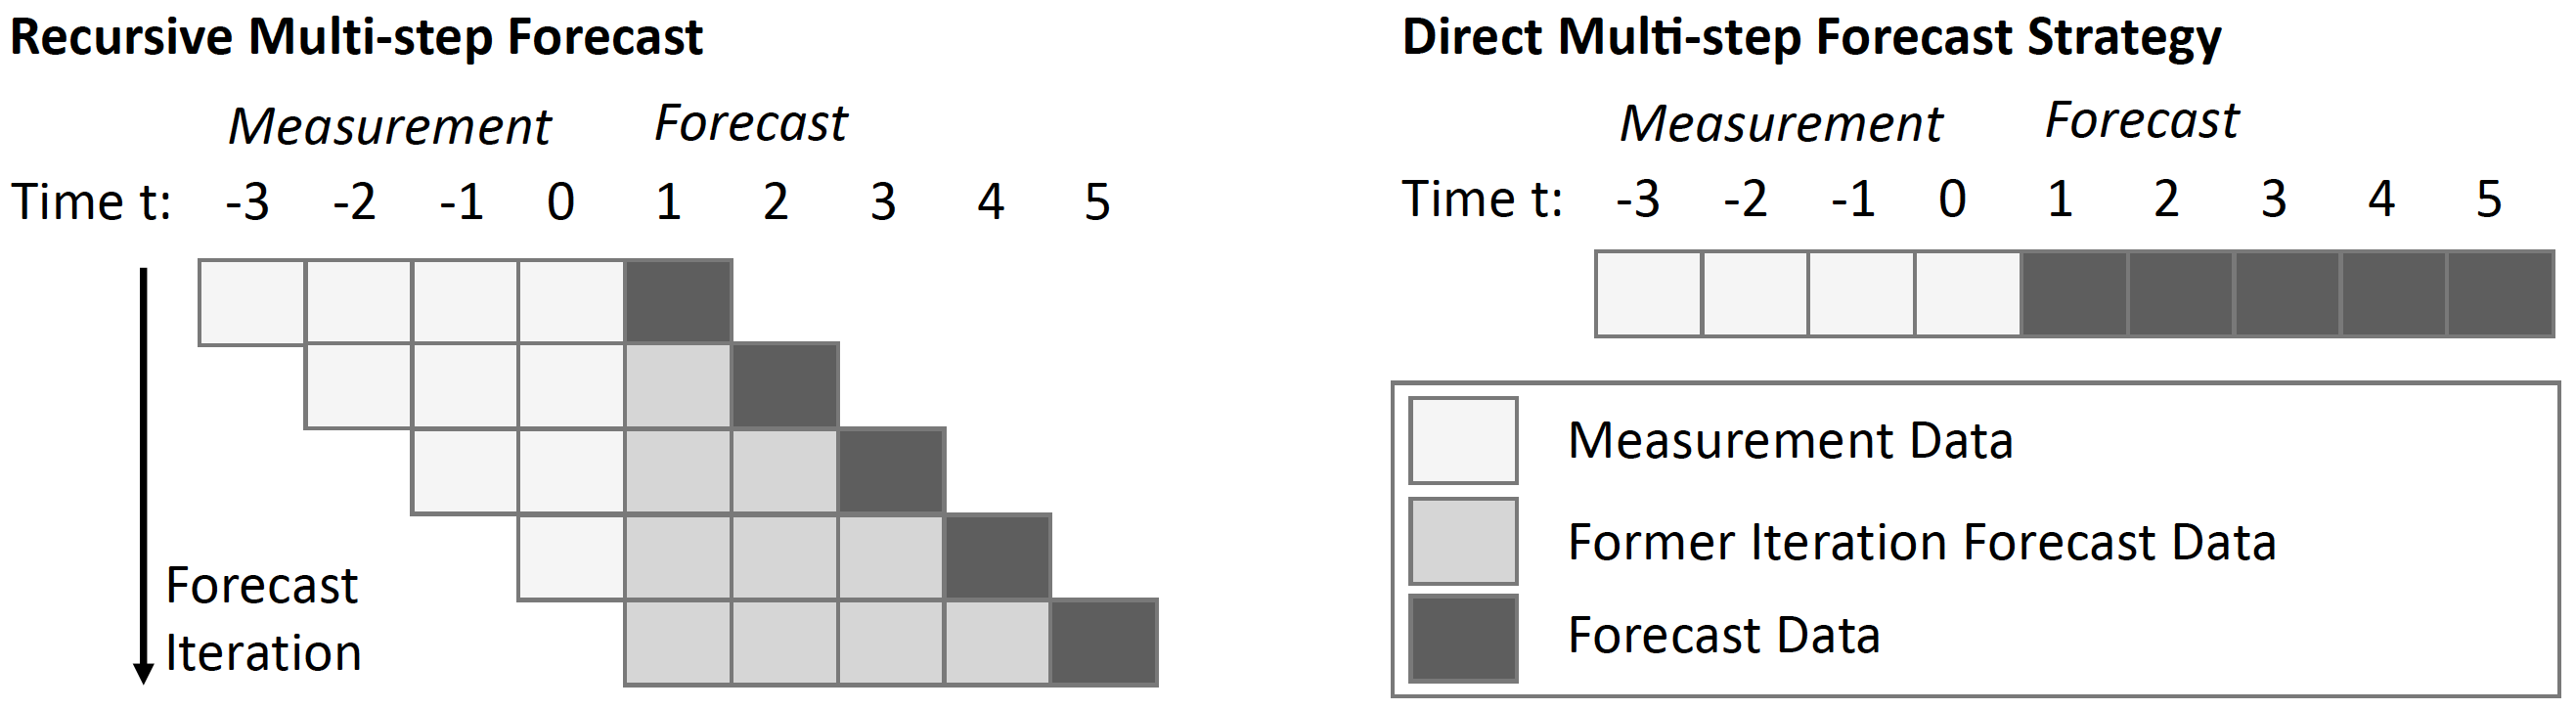 | 
|:--:| 
| *Source: Own figure.* |

## Encoding Cyclic Calendar-based Features <a name="cyclic"></a>

When encoding calendar-based variables, there are different ways to approach this:
* Encode them as numbers (e.g., January, February, … = 1, 2, ….). **Problem**: Numbers indicate "closeness", "order" and linear increasing relationship that may not be useful for all models.
* Dummy-encode/One-Hot-Encode (e.g. Monday, Tuesday, … = (1,0,0,0,0,0,0), (0,1,0,0,0,0,0), …) the variables. This is the most common approach. **Problem**: However, no information about order is preserved. For instance, January and February are somewhat similar. Also, cyclic properties are not preserved, e.g. December and January may also be considered similar.
* Model seasonal properties using Sine and Cosine functions!

As described in [this post,](https://towardsdatascience.com/forecasting-energy-consumption-using-neural-networks-xgboost-2032b6e6f7e2) (also see <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_14#Sec2">Section 14.2</a> of the book) one can encode the seasonal properties using Sine and Cosine functions as visualised in the following figure from the post:



| <img src="https://miro.medium.com/max/1400/1*GuL5Cq_yBBKY6aqUD0jtDQ.png" alt="Encoding" style="float: left; margin-right: 10px;" />| 
|:--:| 
| *Source: [Blog Post on Towards Datascience.](https://towardsdatascience.com/forecasting-energy-consumption-using-neural-networks-xgboost-2032b6e6f7e2)* |


# Preparing the Data for Training and Testing <a name="inputoutput"></a>

We can now use Pandas and the Numpy numerical library to create features. For this tutorial, let's consider the very short-term forecasting task of predicting the load 6 hours in advance. We model the following features to use in a model for _direct_ forecasting, so that we can use whatever is available at the time the forecast is issued, such as the current forecast or historical information. 

Numerical input should be scaled, for example using standardisation or min/max scaling (here standard scaling). Categorical data should be one-hot coded (or dummy coded).

In [10]:
load = reduced_data["S12"].to_frame().resample("1H").mean()
# add sine/cosine encoding for hour of day and month of the year for the time stamp of the forecast issue time.
load["hour_x"] = np.sin(np.radians((360/24) * load.index.hour))
load["hour_y"] = np.cos(np.radians((360/24) * load.index.hour))
load["month_x"] = np.sin(np.radians((360/12) * load.index.month))
load["month_y"] = np.cos(np.radians((360/12) * load.index.month))

# we had the first six values of the forecast as well as a moving average of the last 12 hours before the issue time
load = pd.concat([load, nwp.iloc[:,:6]], axis=1)
load["temperature_rolling_mean"] = nwp.iloc[:,0].rolling(window=12).mean()

# Add lags up to one day
MAX_LAG = 24
for lag in range(MAX_LAG, 0, -1):
    load["load_lag_" + str(lag)] = load.S12.shift(lag)

scaler = MinMaxScaler()
load = pd.DataFrame(scaler.fit_transform(load), index=load.index, columns=load.columns)

# add calendar-based variables as categorical data so we can compare it against the sine/cosine encoding. It is already min/max scaled
load["day_of_week"] = load.index.weekday
load["hour_of_day"] = load.index.hour
load["month_of_year"] = load.index.month
load["weekend"] = load.index.weekday.isin([5,6])
load = pd.get_dummies(load, columns=["day_of_week", "hour_of_day", "month_of_year"])

load["2018-07-02":"2018-07-02"]

,S12,hour_x,hour_y,month_x,month_y,temp_0,temp_1,temp_2,temp_3,temp_4,...,month_of_year_3,month_of_year_4,month_of_year_5,month_of_year_6,month_of_year_7,month_of_year_8,month_of_year_9,month_of_year_10,month_of_year_11,month_of_year_12
2018-07-02 00:00:00+00:00,0.168788,0.500000,1.000000,0.25,0.066987,0.679861,0.676396,0.675892,0.688731,0.709506,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 01:00:00+00:00,0.115096,0.629410,0.982963,0.25,0.066987,0.683565,0.682832,0.693504,0.711635,0.743655,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 02:00:00+00:00,0.160860,0.750000,0.933013,0.25,0.066987,0.690046,0.700529,0.716377,0.745534,0.773419,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 03:00:00+00:00,0.218705,0.853553,0.853553,0.25,0.066987,0.707870,0.723512,0.750229,0.775080,0.794878,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 04:00:00+00:00,0.339480,0.933013,0.750000,0.25,0.066987,0.731019,0.757527,0.779735,0.796381,0.816336,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 05:00:00+00:00,0.496555,0.982963,0.629410,0.25,0.066987,0.765278,0.787175,0.801006,0.817682,0.841947,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 06:00:00+00:00,0.620691,1.000000,0.500000,0.25,0.066987,0.795139,0.808550,0.822278,0.843106,0.850485,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 07:00:00+00:00,0.640260,0.982963,0.370590,0.25,0.066987,0.816667,0.829924,0.847667,0.851580,0.867559,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 08:00:00+00:00,0.573769,0.933013,0.250000,0.25,0.066987,0.838194,0.855436,0.856130,0.868530,0.870789,...,False,False,False,False,True,False,False,False,False,False
2018-07-02 09:00:00+00:00,0.642775,0.853553,0.146447,0.25,0.066987,0.863889,0.863939,0.873056,0.871736,0.880480,...,False,False,False,False,True,False,False,False,False,False


The feature data set has now has the followig columns:

In [11]:
load.columns

Index(['S12', 'hour_x', 'hour_y', 'month_x', 'month_y', 'temp_0', 'temp_1',
       'temp_2', 'temp_3', 'temp_4', 'temp_5', 'temperature_rolling_mean',
       'load_lag_24', 'load_lag_23', 'load_lag_22', 'load_lag_21',
       'load_lag_20', 'load_lag_19', 'load_lag_18', 'load_lag_17',
       'load_lag_16', 'load_lag_15', 'load_lag_14', 'load_lag_13',
       'load_lag_12', 'load_lag_11', 'load_lag_10', 'load_lag_9', 'load_lag_8',
       'load_lag_7', 'load_lag_6', 'load_lag_5', 'load_lag_4', 'load_lag_3',
       'load_lag_2', 'load_lag_1', 'weekend', 'day_of_week_0', 'day_of_week_1',
       'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5',
       'day_of_week_6', 'hour_of_day_0', 'hour_of_day_1', 'hour_of_day_2',
       'hour_of_day_3', 'hour_of_day_4', 'hour_of_day_5', 'hour_of_day_6',
       'hour_of_day_7', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13', 'hour_of_day_14',
       'hour_of_day_15', 'hour_

Note, that generally there are different ways that one can use to preprocess data. Here we use standard scaling, but you may also try Min-/Max-Scaling, Logarithmic Transforms or Box-Cox-Transforms, depending on the models used. See <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_6#Sec2">Section 6.1.3</a>.


Now we prepare the target and drop it from the feature data. Here we follow the *direct* forecasting scheme. The target is prepared for multi-output regression models in the form (n samples, H), where H is the forecast horizon in hours. Of course, feel free to code an iterative scheme!

In [12]:
H = 6
target = pd.DataFrame(index = load.index)
for h in range( 6):
    target["target_" + str(h)] = load.S12.shift(-h)
load = load.drop("S12", axis=1)

target["2018-07-02":"2018-07-02"]

,target_0,target_1,target_2,target_3,target_4,target_5
2018-07-02 00:00:00+00:00,0.168788,0.115096,0.160860,0.218705,0.339480,0.496555
2018-07-02 01:00:00+00:00,0.115096,0.160860,0.218705,0.339480,0.496555,0.620691
2018-07-02 02:00:00+00:00,0.160860,0.218705,0.339480,0.496555,0.620691,0.640260
2018-07-02 03:00:00+00:00,0.218705,0.339480,0.496555,0.620691,0.640260,0.573769
2018-07-02 04:00:00+00:00,0.339480,0.496555,0.620691,0.640260,0.573769,0.642775
2018-07-02 05:00:00+00:00,0.496555,0.620691,0.640260,0.573769,0.642775,0.659763
2018-07-02 06:00:00+00:00,0.620691,0.640260,0.573769,0.642775,0.659763,0.634032
2018-07-02 07:00:00+00:00,0.640260,0.573769,0.642775,0.659763,0.634032,0.629040
2018-07-02 08:00:00+00:00,0.573769,0.642775,0.659763,0.634032,0.629040,0.581286
2018-07-02 09:00:00+00:00,0.642775,0.659763,0.634032,0.629040,0.581286,0.537632


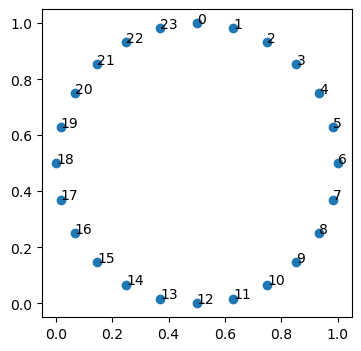

In [13]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
ax.scatter(load["hour_x"].iloc[:24], load["hour_y"].iloc[:24])
for h in range(24):
    ax.annotate(load.index.hour[h], (load["hour_x"].iloc[h], load["hour_y"].iloc[h]))

We have now generated 80 candidate features from our initial columns, which we hope will provide the model with richer predictive information! But with different encodings, there is still redundancy and highly collinear variables (see [Chapter 13.6](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_13#Sec6)). So let's define a feature set for our first models:

In [14]:
HOUR_MONTH = ['hour_x', 'hour_y', 'month_x', 'month_y']
DOW = ['day_of_week_0', 'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4', 'day_of_week_5', 'day_of_week_6']
NWP = ['temp_0', 'temp_1', 'temp_2', 'temp_3', 'temp_4', 'temp_5', 'temperature_rolling_mean']
LAGGED_LOAD = ['load_lag_24', 'load_lag_23', 'load_lag_22', 'load_lag_21',
       		'load_lag_20', 'load_lag_19', 'load_lag_18', 'load_lag_17',
       		'load_lag_16', 'load_lag_15', 'load_lag_14', 'load_lag_13',
       		'load_lag_12', 'load_lag_11', 'load_lag_10', 'load_lag_9', 'load_lag_8',
       		'load_lag_7', 'load_lag_6', 'load_lag_5', 'load_lag_4', 'load_lag_3',
       		'load_lag_2', 'load_lag_1']

FEATURES = HOUR_MONTH + DOW + NWP + LAGGED_LOAD 		

The available data is split up to train and test data. Here, we use a blocked cross-validation scheme (see Section [Cross-validation for time series](#crossvalidation) of this tutorial or book [Chapter 8.1.3](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_8#Sec2) for some other possible schemes).

In [15]:
X, Y = load.iloc[MAX_LAG:-H,:].loc[:,FEATURES], target.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6673, 42) (2225, 42) (6673, 6) (2225, 6)


# Model Fitting <a name="modelfit"></a>

This section considers fitting the models to the training data. More details on training data can be found in <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_8">Chapter 8</a>.
 

## Benchmark/Baseline Models <a name="benchmark"></a>
For time series models it can make sense to start with simple benchmarks. For one-step ahead forecasting this may be the *persistence model*, i.e., predicting the same value as in the previous time step. For seasonal data this may also be the value of the last season, e.g., last Monday for a Monday or the value from last year. Or moving averages of the previous timesteps (or previous several seasons). For some seasonal data such *naive models* can be surprisingly hard to beat. Some standard benchmark models can be found in <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_9">Chapter 9</a>.

Given the weekly seasonality and task of predicting 24 hours ahead, using last week's load at the same time could be a reasonable benchmark. This model is sometimes referred to as *seasonal persistence* model:

In [16]:
y_hat_naive = Y.shift(168).loc[X_test.index]
y_hat_sma = np.divide(Y.shift(168).loc[X_test.index] + Y.shift(168*2).loc[X_test.index] + Y.shift(168*3).loc[X_test.index] + Y.shift(168*4).loc[X_test.index], 4)

Let's use the mean absolute percentage error and root mean square error (see [Chapter 7](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_7) on point forecast measures) as a metric:

In [17]:
def mape(y_true, y_pred): 
    return mean_absolute_percentage_error(y_true, y_pred) * 100

def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

print(f"MAPE Naive: {mape(y_test, y_hat_naive):.2f}, SMA: {mape(y_test, y_hat_sma):.2f}")
print(f"RMSE Naive: {rmse(y_test, y_hat_naive):.4f}, SMA: {rmse(y_test, y_hat_sma):.4f}")

MAPE Naive: 19.44, SMA: 20.48
RMSE Naive: 0.1193, SMA: 0.1155


Now let's fit some sklearn machine learning models to the data and compare them to the benchmark in terms of RMSE. 

Our first simple model is the _k_ nearest neighbors (see [Chapter 10.1](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_10#Sec1)).

In [18]:
# Fit a KNN regression model
model = KNeighborsRegressor()
model.fit(X_train, y_train)

y_hat_knn = pd.DataFrame(model.predict(X_test), index=y_test.index)
print(f"RMSE SMA: {rmse(y_test, y_hat_sma):.4f}, KNN: {rmse(y_test, y_hat_knn):.4f}")


RMSE SMA: 0.1155, KNN: 0.0849


Great it beat the simple benchmark by quite a margin!

Let's now try another simple model, a L2-penalized linear regression model (see [Chapter 9.3](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_9#Sec4) on Multiple Linear Regression and [Chapter 8.2.4](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_8#Sec6) on Weight Regularisation).
 
KNN is already capable of multi-output regression to predict several time steps ahead. The linear model needs to be wrapped in the MultiOutputRegressor model, which fits one model per output variable.

In [19]:
model = MultiOutputRegressor(Ridge())
model.fit(X_train, y_train)

y_hat_linear = pd.DataFrame(model.predict(X_test), index=y_test.index)

print(f"KNN: {rmse(y_test, y_hat_knn):.4f}, Ridge Regression: {rmse(y_test, y_hat_linear):.4f}")

KNN: 0.0849, Ridge Regression: 0.0772


Our second model cannot provide any improvement in terms of RMSE. 

You can also visually compare the forecast to the actual by plotting sample forecasts. Try different time stamps! You can see that different models perform differently at different times. So there is still room for improvement!

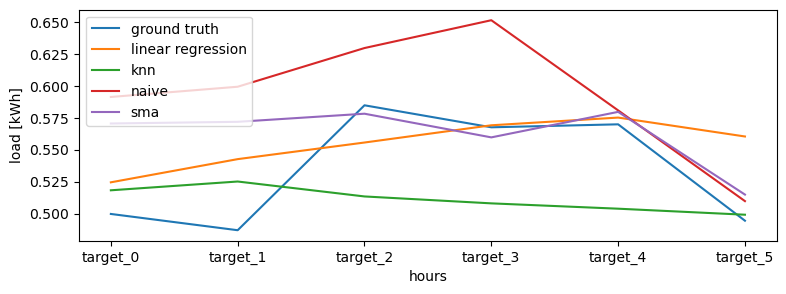

In [20]:
ISSUE_TIME = "'2018-10-19 06:00:00"

fig, ax = plt.subplots(figsize=(9,3))
ax.plot(y_test.loc[ISSUE_TIME],label='ground truth')
ax.plot(y_hat_linear.loc[ISSUE_TIME],label='linear regression')
ax.plot(y_hat_knn.loc[ISSUE_TIME],label='knn')
ax.plot(y_hat_naive.loc[ISSUE_TIME],label='naive')
ax.plot(y_hat_sma.loc[ISSUE_TIME],label='sma')
ax.set_ylabel('load [kWh]')
ax.set_xlabel('hours')
plt.legend()

## Comparing Encodings for categorical variables <a name="encodings"></a>

As discussed above, calendar-based categorical variables can be encoded using one-hot encoding or using sine/cosine. The latter has the advantage of using fewer variables and incorporating knowledge about the distance of, for instance, the hours of the day at night (11pm is close to 1 am) or months (January is close to December). 

In [21]:
HOUR_MONTH_OH = [ 'hour_of_day_0', 'hour_of_day_1', 'hour_of_day_2',
			'hour_of_day_3', 'hour_of_day_4', 'hour_of_day_5', 'hour_of_day_6',
			'hour_of_day_7', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
			'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13', 'hour_of_day_14',
			'hour_of_day_15', 'hour_of_day_16', 'hour_of_day_17', 'hour_of_day_18',
			'hour_of_day_19', 'hour_of_day_20', 'hour_of_day_21', 'hour_of_day_22',
			'hour_of_day_23', 'month_of_year_1', 'month_of_year_2',
			'month_of_year_3', 'month_of_year_4', 'month_of_year_5',
			'month_of_year_6', 'month_of_year_7', 'month_of_year_8',
			'month_of_year_9', 'month_of_year_10', 'month_of_year_11',
			'month_of_year_12']

In [22]:
knn = KNeighborsRegressor()
X, Y = load.iloc[MAX_LAG:-H,:].loc[:,HOUR_MONTH + DOW + NWP + LAGGED_LOAD], target.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)
print(f"RMSE SIN COS encoding: {rmse(y_test, y_hat):.4f}")

knn = KNeighborsRegressor()
X, Y = load.iloc[MAX_LAG:-H,:].loc[:,HOUR_MONTH_OH + DOW + NWP + LAGGED_LOAD], target.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=False)
knn.fit(X_train, y_train)
y_hat = knn.predict(X_test)
print(f"RMSE One-hot encoding: {rmse(y_test, y_hat):.4f}")

RMSE SIN COS encoding: 0.0849
RMSE One-hot encoding: 0.0709


Here, we find that one hot encoding works better than the sine/cosine encoding.

## Fitting a neural network using Tensorflow <a name="ann"></a>

Finally, we use a simple artificial neural network using Tensorflow. A second popular deep learning library is [PyTorch](https://pytorch.org/). Both are powerful and a preference mostly a matter of taste. There are different ways to model ANN in Tensorflow. For simple archicture, for instance of multiple fully-connected leayers the easiest ist the [Keras Sequential API](https://www.tensorflow.org/guide/keras/sequential_model). 

We model a simple fully-connected artificial neural network with two fully-connected layers earch with 90 nodes. We use the __relu__ activation function for the hidden layers. We use the ADAM optimiser to find the optimal weights. Recall that for regression the output layers has a __linear__ activation function and we minimise the __mean squared loss__. More information on all these models an their hyperparameters can be found in <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_10">Chapter 10</a>.

The `summary()` function shows us the architecture and number of trainable parameters (weights). 

In [23]:
model = Sequential()
model.add(Input(shape=X_test.shape[1]))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=H, activation='linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=["mean_squared_error"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                3750      
                                                                 
 dense_1 (Dense)             (None, 50)                2550      
                                                                 
 dense_2 (Dense)             (None, 6)                 306       
                                                                 
Total params: 6,606
Trainable params: 6,606
Non-trainable params: 0
_________________________________________________________________


2023-05-01 20:08:30.876270: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Now let's train our model using the same features as for the best KNN model! Let's shuffle the training data this time and add a validation split of 10% to calculate training characteristics. Let's fit the KNN benchmark on the same train/test split. 

In [24]:
X, Y = load.iloc[MAX_LAG:-H,:].loc[:,HOUR_MONTH_OH + DOW + NWP + LAGGED_LOAD], target.iloc[MAX_LAG:-H,:]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, shuffle=True)

history = model.fit(X_train.values.astype("float32"), 
                    y_train.values.astype("float32"), 
                    validation_split=0.10,
                    epochs=100, 
                    batch_size=16,
                    verbose=False
)

knn = KNeighborsRegressor()
knn.fit(X_train, y_train);

y_hat_ann = pd.DataFrame(model.predict(X_test.astype("float32")), index=y_test.index)
print(f"RMSE ANN: {rmse(y_test, y_hat_ann):.4f}")

y_hat_knn = knn.predict(X_test)
print(f"RMSE KNN: {rmse(y_test, y_hat_knn):.4f}")

70/70 [==============================] - 0s 570us/step
RMSE ANN: 0.0441
RMSE KNN: 0.0595


This model may or may not now perform worse than our initial baseline! If you repeat the process of running the above cell, you will notice that compared to the models above, this time your resulting model will depend on the random initialisation.

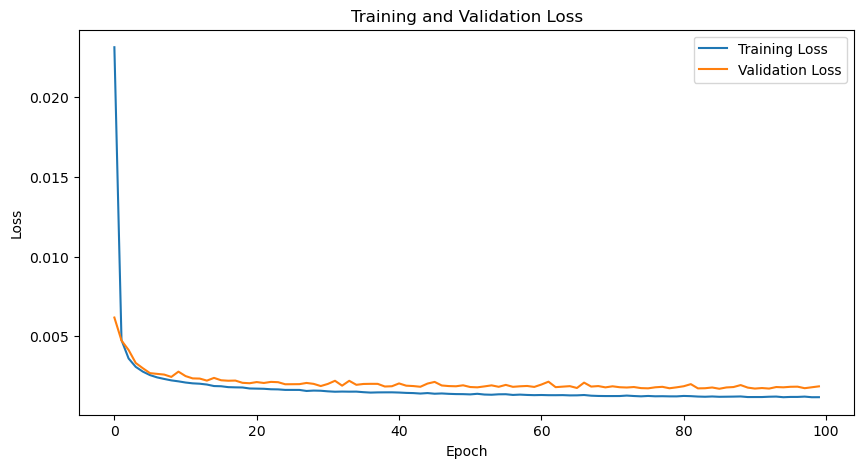

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_title('Training and Validation Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

As a first diagnosis we want to see the learning curve (see [Chapter 8.2.5](https://link.springer.com/chapter/10.1007/978-3-031-27852-5_8#Sec6)). We can see signs of overfitting as the gap between training and validation loss increases. So some additional tuning is needed to improve and stabilise the results!

Here are some ideas to try to improve the model:
- Try different regularisation methods to avoid possible overfitting (see chapter 8.2 on hyperparameters, weight regularisation and other regularisation methods to avoid overfitting), 
- try to train the model on more data for your specific problem (use it as a _global model_ and include more data from the above dataset),
- try to add different features (longer time window?).

The next section will show you some more ways to diagnose your model (no matter which forecasting model you use).

# Model diagnostics <a name="diagnostics"></a>

A good forecasting method will yield residuals with the following properties (see <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_7#Sec6">Section 7.5</a>.):
* *The residuals are uncorrelated.* If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
* *The residuals have zero mean.* If the residuals have a mean other than zero, then the forecasts are biased.

In addition to these essential properties, it is useful (but not necessary) for the residuals to also have the following two properties:
* The residuals have constant variance.
* The residuals are normally distributed.

The following plots show exemplarily diagnostic plots of a historgram of residuals (top) and the autocorrelation plot of the residuals (bottom).

| | 
|:--:|
| <img src="https://otexts.com/fpp3/fpp_files/figure-html/GSPhist-1.png" alt="histogram" style="float: left; margin-right: 10px;" /> | 
| <img src="https://otexts.com/fpp3/fpp_files/figure-html/GSPacf-1.png"   alt="residuals AR" style="float: left; margin-right: 10px;" /> | 
| *Source: [FPP book](https://otexts.com/fpp3/).* |



In [26]:
step_ahead_errors = y_hat_ann.iloc[:,0]-y_test.iloc[:,0]

Mean: 0.01


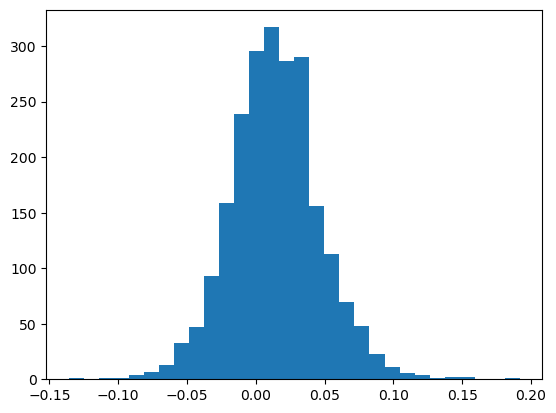

In [27]:
plt.hist(step_ahead_errors, bins=30);
print(f"Mean: {step_ahead_errors.mean():.2f}")

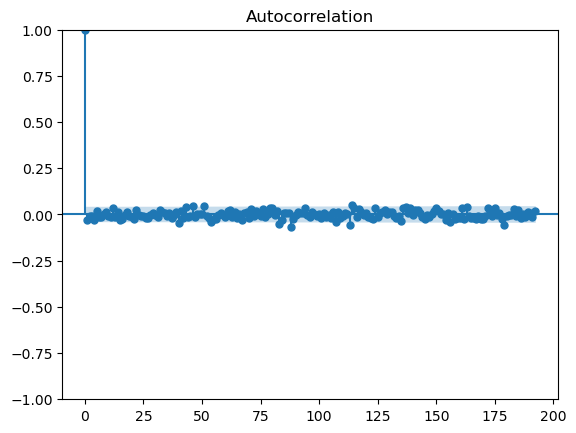

In [28]:
acf = plot_acf(step_ahead_errors, lags=8*24)

The diagnostics show that there is still room for improvement in the model, as the distribution of errors shows that the model is biased, and the autocorrelation shows that there is still information not properly included in the model!

## 👉 *Main Take Away Messages*
- *Start by establishing some simple, but also stronger benchmarks (simple seasonal models and some statistical or simple ML models) before going to more complex models like LSTM, CNN or transformers.*
- *Don't just look at the RMSE, but also use plots of the forecasts and diagnostics plots of the errors to see where your model still fails. Then try different features or feature encodings to improve your model.* 


# Cross-validation for time series  <a name="crossvalidation"></a>

When trying to compare different version of a model (e.g., trying different features or model hyper-parameters), it is best practice to use *cross validation*. Cross validation is a tool to try to analyze how well a model generalises to new unseen data. Forecast models must be tested on unseen data to ensure that the forecaster is not unrealistically tailoring (subconsciously or otherwise) the model to score higher than would be possible in practice. In real applications the future data is not available and forecasters would not have the advantages of knowing the actual values in advance. Further information on cross validation can be found in <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_8">Chapter 8</a> of the book.

Tuning the parameters can generate substantial performance gain, but this can also lead to overfitting. Thus, we use a cross-validation scheme to understand the impact of several values for the  hyper-parameters by splitting the training set in several training and validation folds. Here, we are tuning the parameter *k* of *k*-nearest neighbor. 

We try 3 cross-validation approaches:
- *shuffled*, we take random samples for each fold
- *by blocks*, we take folds that are continuous time blocks all with the same duration     
- *by time series split*, we take folds that are continuous time blocks of different durations (for example fold 1 is two months, fold 2 is three months,...)

See below schematics of blocked (left), time series (middle) and shuffled (right) folds:


| 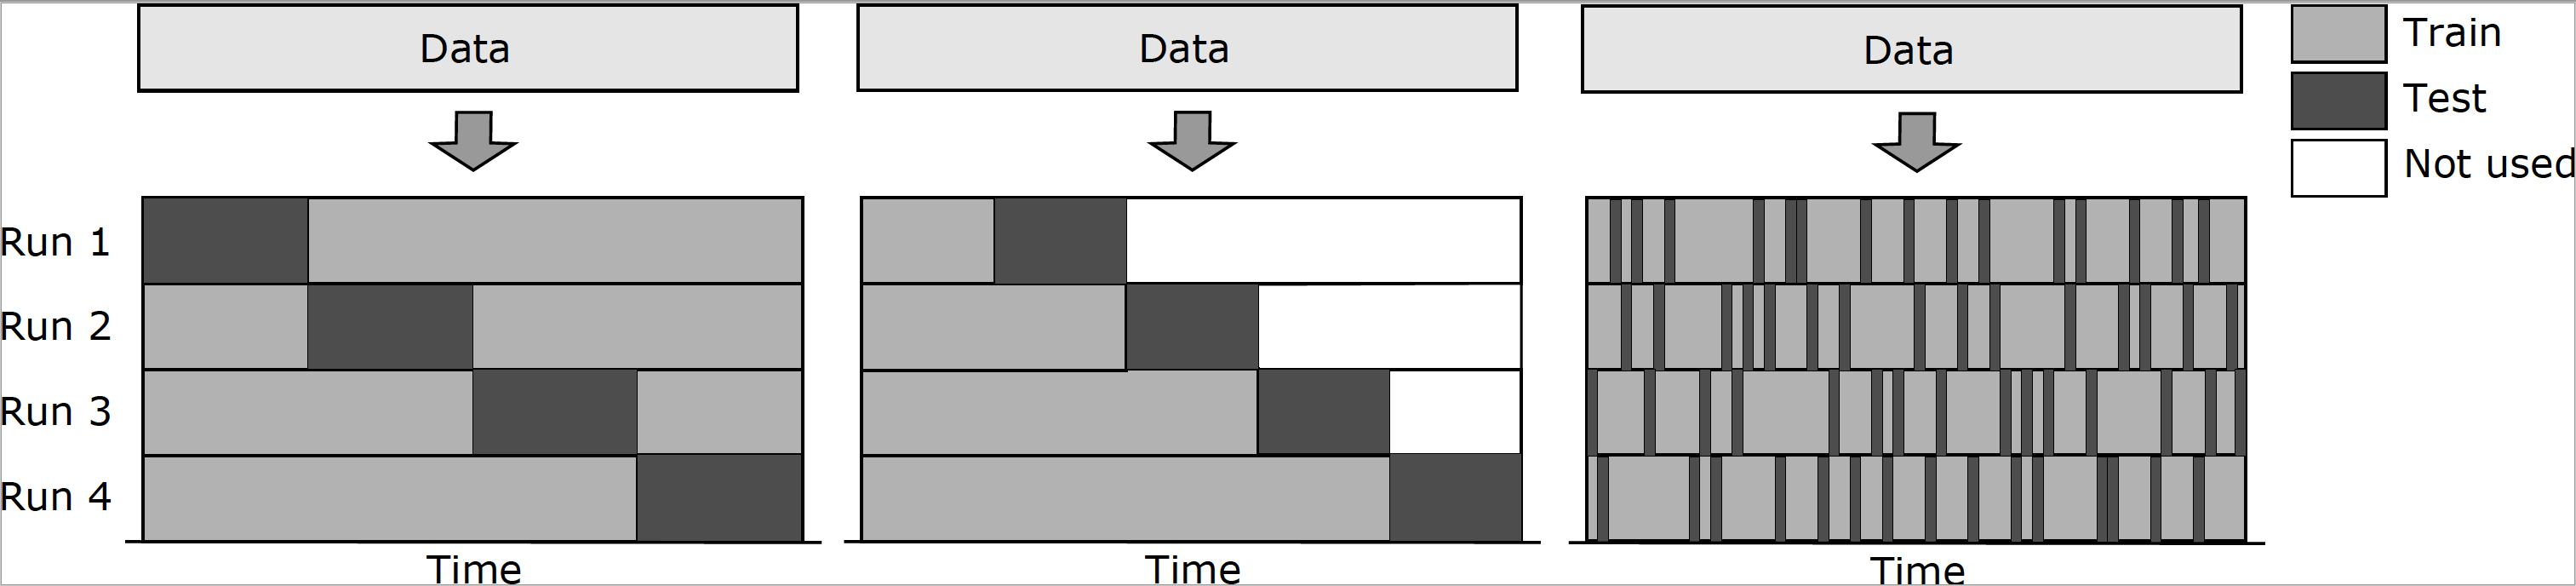 | 
|:--:| 
| *Source: Own figure.* |



Now let's compare the errors using the three schemes.

In [29]:
X, Y = load.iloc[MAX_LAG:-H,:].loc[:,HOUR_MONTH_OH + DOW + NWP + LAGGED_LOAD], target.iloc[MAX_LAG:-H,:]

N  = 4
knn = KNeighborsRegressor()
knn_parameters = {"n_neighbors" : [3, 6, 12, 18, 24]}

# Using shuffle=False, the KFold represents "blocked cross-validation", i.e. consequitive blocks remain together
gs_cv_block = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=KFold(n_splits=N, shuffle=False), n_jobs=-1, return_train_score=True)
gs_cv_block.fit(X_train, y_train)
print(gs_cv_block.best_params_) 
y_hat = gs_cv_block.predict(X_test)
print(f"Test MAPE Blocked: {rmse(y_test, y_hat):.4f}")

# Using shuffle=True, the KFold represents regular, completely shuffled cross-validation
gs_cv_shuffle = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=KFold(n_splits=N, shuffle=True), n_jobs=-1, return_train_score=True)
gs_cv_shuffle.fit(X_train, y_train)
print(gs_cv_shuffle.best_params_) 
y_hat = gs_cv_shuffle.predict(X_test)
print(f"Test MAPE Shuffled: {rmse(y_test, y_hat):.4f}")

# Sklearn also includes a CV scheme for time series
gs_cv_ts = GridSearchCV(knn, knn_parameters, scoring="neg_mean_squared_error", cv=TimeSeriesSplit(n_splits=N), n_jobs=-1, return_train_score=True)
gs_cv_ts.fit(X_train, y_train)
print(gs_cv_ts.best_params_) 
y_hat = gs_cv_ts.predict(X_test)
print(f"Test MAPE Time Series CV: {rmse(y_test, y_hat):.4f}")

{'n_neighbors': 12}
Test MAPE Blocked: 0.0537
{'n_neighbors': 12}
Test MAPE Shuffled: 0.0537
{'n_neighbors': 6}
Test MAPE Time Series CV: 0.0563


Firstly, when comparing the results of the test set, they all improve on the un-tuned baseline model and have a similar effect. However, they produce slightly different results. How do you choose your procedure?

In cross-validation schemes, an important consideration is that the folds should generally be independent and follow the distribution of the actual data. You also want to use as much of your data as possible. We analyse this by plotting the negative MSE errors of the different plots.

<Axes: xlabel='None-param_n_neighbors', ylabel='level_0'>

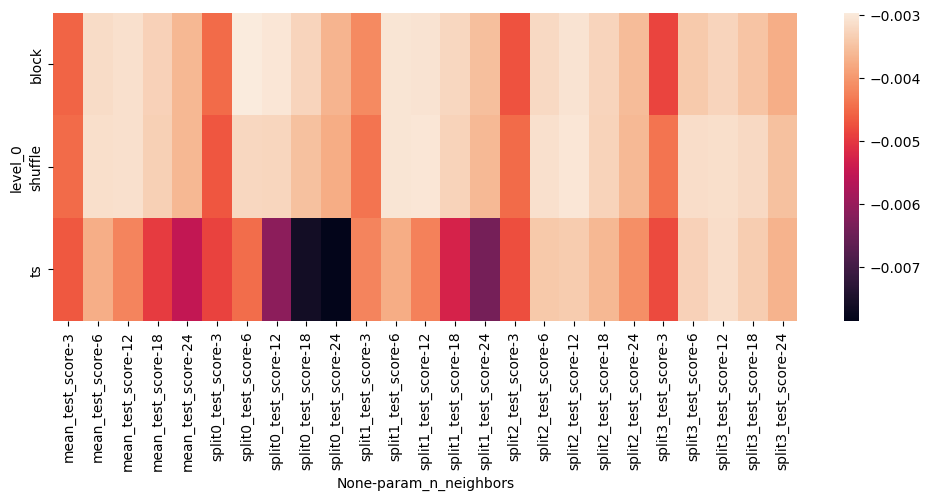

In [30]:
cv_results = pd.concat([pd.DataFrame(gs_cv_ts.cv_results_), pd.DataFrame(gs_cv_shuffle.cv_results_), pd.DataFrame(gs_cv_block.cv_results_)], keys=["ts", "shuffle", "block"]).reset_index()
fig, ax = plt.subplots(figsize=(12,4))   
sns.heatmap(cv_results.pivot(index="level_0", columns="param_n_neighbors", values=["mean_test_score", "split0_test_score", "split1_test_score", "split2_test_score", "split3_test_score"]), ax=ax)

We see that the errors across the folds are similar for shuffled and blocked CV, but some folds have much higher errors for time split.

For the time series scheme, this is due to the fact that the distribution in the folds varies greatly due to the annual seasonality, violating the latter assumption of the same distribution. The shuffled scheme has a more stable distribution across the folds compared to the other schemes. However, given the lagged, autocorrelated variables, the shuffled scheme violates the independence assumption, as data 'leaks' between the folds. This may be fine if the errors are uncorrelated (see [2] if you want to delve deeper into this topic). A blocked scheme with some large N might be a compromise here. However, the shuffled and blocked schemes are essentially using data from "the future", which may also not be alright in settings where your time series is non-stationary, as this may make your model overly confident.

## 👉 *Main Take Away Message*.
- The cross-validation scheme you choose will be critical to achieving good generalisation results. An unrealistic cross-validation scheme may lead to overly optimistic results on the validation set, which in turn will lead to poor results on the unseen test set. A time series specific split should most often be the starting point for time series prediction. However, if this leads to problems with your available data, a blocked theme may also be appropriate. Read more about this [here](https://arxiv.org/pdf/2203.10716.pdf).


# Where to go from here? <a name="sota"></a>

Some ideas on where to contribute in the area of ML and load forecasting:
- *Better Bechmarking Frameworks*: Currently, there are a lot of papers that don't compare their models to each other, as a standardized benchmark (framework) is missing. A huge benefit to the load forecasting community would be reference implementations and standardised datasets (contact me if you are interested in contributing :)),
- *State-of-the-art deep models*: Can temporal variants of transformers outperform temporal convolutional models? Or try Gradient Boosting [XGBoost](https://xgboost.readthedocs.io/en/latest/) or [LightGBM](https://lightgbm.readthedocs.io/en/latest/).
- *Probabilistic models*: As you see, especially for only few households forecast errors are high. Here, probabilistic forecasts (intervals, densities, scenarios) can inform more than point forecasts. The marginal distributions are typically complex (multi-model, skewed), hence data-drive approaches can be interesting here! See <a href="https://link.springer.com/chapter/10.1007/978-3-031-27852-5_11">Chapter 11</a> for more details on probabilistic forecasts.
- *Hierarchical and graphical models*: The electric power system is hierarchial and household locations are spatial information that could be utilised. Consider hierarchical and graphical models for load forecasting! The dataset used here is a hierarchical dataset. 
- *Multivariate models*: Often for buildings there are several relevant time series, e.g. the thermal and electric load as well as load from EV. Given that all of those are depending on similar features (weather, occupancy, ...) once could consider forecasting all domains at once!

See also <a href="https://link.springer.com/content/pdf/bbm:978-3-031-27852-5/1?pdf=chapter%20toc">Appendix C for more ideas!</a>

# References 

- **[1]** *Haben, S., Arora, S., Giasemidis, G., Voss, M., & Greetham, D. V. (2021). Review of low voltage load forecasting: Methods, applications, and recommendations. Applied Energy, 304, 117798.* [Applied Energy Version](https://www.sciencedirect.com/science/article/abs/pii/S0306261921011326). [Preprint Version](https://arxiv.org/pdf/2106.00006.pdf).
- **[2]** *Hewamalage, Hansika, Klaus Ackermann, and Christoph Bergmeir. Forecast Evaluation for Data Scientists: Common Pitfalls and Best Practices. arXiv preprint arXiv:2203.10716 (2022).* [Link](https://arxiv.org/pdf/2203.10716.pdf).


# Selected Ressources on Time Series 

## Tools and Libraries 

### **Tools in Python** 

- [sktime](https://www.sktime.org/en/stable/) and [tslearn](https://github.com/tslearn-team/tslearn/tree/main/tslearn) are two similar packages that allow to apply sklearn models to time series problems. Both are capable of supporting forecasting, but also clustering and classification tasks. tslearn ist stronger in time series clustering and has implemented many popular time series distance measures such as [Dynamic Time Warping](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw.html#tslearn.metrics.dtw) or the [Matrix Profile](https://tslearn.readthedocs.io/en/stable/user_guide/matrix-profile.html#matrix-profile) that can be useful in comparing time series and finding (recurring) pattern.
- [statsmodels](https://www.statsmodels.org/devel/api.html#statsmodels-tsa-api) Statsmodels is a general stats library, but it contains different time series specific statistical tests and models.
- [tsfresh](https://tsfresh.readthedocs.io/en/latest/index.html) is a fantastic python package that can automatically calculate a large number of time series features. This can be used for forecasting tasks, but also for classification or clustering of time series.
- [Facebook Prophet](https://facebook.github.io/prophet/): A comprehensive industry-focused suite of a group of forecasting models that automates much of the modeling process.
- [Darts](https://unit8co.github.io/darts/#forecasting-models): Another comprehensive industry-focused suite. It contains strong statistical models like ARIMA or THETA, wrappers for sklearn, strong ML models like Gradient Boosting and deep learning models like LSTM/GRU, NBEATS, TCN and Transformers. It includes also Prophet. Compared to Prophet, this gives you more choices from simple to sophisticated and includes state-of-the-art models from deep learning.
- Visualization: Your favorite Python library will likely also have some ways to plot time series. For simple in the easiest case you can start with a line chart ([Matplotlib](https://matplotlib.org/3.5.1/api/_as_gen/matplotlib.pyplot.plot.html) or [Seaborn](https://seaborn.pydata.org/generated/seaborn.lineplot.html#seaborn.lineplot)). Others make you handle time series more explicitly like [Plotly](https://plotly.com/python/time-series/). However, besides line plots, you may also consider heat maps, histograms, box plots, scatter plots, and the more specialized plots such as autocorrelation plots are built into [pandas](https://pandas.pydata.org/docs/reference/api/pandas.plotting.autocorrelation_plot.html) or [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.acorr.html). Of course there is a plethora of other specialized sometimes useful plots, e.g. [clock plots](https://github.com/esc-data-science/clock_plot).

### **Tools in R**

- [List of packages by Prof. Hyndamn](https://robjhyndman.com/software/) Prof. Hyndman has co-authored many relevant packages in the R space. From the older very popular [forecast package](https://pkg.robjhyndman.com/forecast/) to "tidyverse" packages [fable](https://github.com/tidyverts/fable) and [feasts](https://github.com/tidyverts/feasts).
- [Facebook Prophet](https://facebook.github.io/prophet/): Prophet (see above) is also available in R.

## Load Datasets 

If you are looking for time series data for your analysis, check out the following sources:

- [Low-voltage Load Data](https://low-voltage-loadforecasting.github.io/) A curated list of datasets from house-hold level to feeder level. You know one that is missing? Let me know or raise [an issue](https://github.com/low-voltage-loadforecasting/low-voltage-loadforecasting.github.io/issues)!
- [Monash Time Series Forecasting Repository](https://forecastingdata.org/). This aims to be a standard repository for reproducible research on time series and has some load data. 
- [CCAI Wiki](https://wiki.climatechange.ai/wiki/Energy_Demand_Forecasting).Some initial ressources on load forecasting can be found in the CCAI Wiki.

See <a href="https://link.springer.com/content/pdf/bbm:978-3-031-27852-5/1?pdf=chapter%20toc">Appendix D</a> for more references or links to specific tools and libraries. 